1.1
-

In [34]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import cumulative_simpson
import matplotlib.pyplot as plt

gn = 4.302e-6  # gravitational constant [kpc (km/s)^2 / M_sun]
mtot = 1e12    # total mass [M_sun]
aa = 35.0      # scale radius [kpc]
nptot = 10**6  # number of particles
my_randState = np.random.default_rng(seed=42)

u = my_randState.random(nptot)
rvals = aa * u**2 / (1 - u**2)
pos_theta = np.arccos(my_randState.uniform(-1, 1, nptot))
pos_phi = my_randState.uniform(0, 2 * np.pi, nptot)
pos = np.vstack([
    rvals * np.sin(pos_theta) * np.cos(pos_phi),
    rvals * np.sin(pos_theta) * np.sin(pos_phi),
    rvals * np.cos(pos_theta)
]).T

In [36]:
def f_E(E):
    qq = np.sqrt(aa / (gn * mtot) * E)
    v_g = np.sqrt(gn * mtot / aa)
    result = ((mtot / (8 * np.sqrt(2) * np.pi**3 * aa**3 * v_g**3)) *
              (1 / (1 - qq**2)**(5/2)) *
              ((3 * np.arcsin(qq)) +
               ((qq * np.sqrt(1 - qq**2)) * (1 - 2 * qq**2) *
                (8 * qq**4 - 8 * qq**2 - 3))))
    return result

def phi(r):
    return gn * mtot / (r + aa)

def distribution(E, r):
    return np.sqrt(phi(r) - E) * f_E(E)

def bound(E):
    return f_E(E) * np.sqrt(gn * mtot / aa - E)



In [38]:
vel = np.zeros((nptot, 3), dtype='float32')
E_max = phi(0)
steps = 1000
all_E = np.linspace(0, E_max, steps)
bounded_steps = bound(all_E)
bounded_cumulative = cumulative_simpson(bounded_steps, x=all_E, initial=0)
velocities = np.zeros(nptot)

for i in range(nptot):
    while True:
        E_maxi = phi(rvals[i])
        max_idx = np.min(np.where(all_E > E_maxi))
        bounded_cumulative_i = bounded_cumulative[0:max_idx]
        A = np.random.uniform(0, bounded_cumulative_i[-1])
        idx = np.argmin(np.abs(bounded_cumulative_i - A))
        E_A = all_E[idx]
        y = np.random.uniform(0, bound(E_A))
        if y <= distribution(E_A, rvals[i]):
            velocities[i] = np.sqrt(2 * (phi(rvals[i]) - E_A))
            break

new_randvec1 = my_randState.random((nptot, 2))
phiv = 2 * np.pi * new_randvec1[:, 0]
thetav = np.arccos(1 - 2 * new_randvec1[:, 1])
vel[:, 0] = velocities * np.sin(thetav) * np.cos(phiv)
vel[:, 1] = velocities * np.sin(thetav) * np.sin(phiv)
vel[:, 2] = velocities * np.cos(thetav)


In [40]:
r_mag = np.linalg.norm(pos, axis=1)
r_hat = pos / r_mag[:, np.newaxis]
v_r = np.sum(vel * r_hat, axis=1)

num_bins = 30
logr_min = np.log10(np.min(r_mag))
logr_max = np.log10(np.max(r_mag))
r_bin = np.logspace(logr_min, logr_max, num_bins)
bin_indices = np.digitize(r_mag, r_bin) - 1
v_mean = np.zeros(num_bins - 1)
bin_centers = (r_bin[:-1] + r_bin[1:]) / 2

for i in range(num_bins - 1):
    in_bin = bin_indices == i
    if np.any(in_bin):
        v_mean[i] = np.mean(v_r[in_bin]**2)
    else:
        v_mean[i] = np.nan

/var/folders/dk/29sc6fl97bjbgd3qznyyjypc0000gq/T/ipykernel_26870/111121881.py:11: RuntimeWarning: invalid value encountered in sqrt
  plt.plot(bin_centers, np.sqrt(analytic_disp), '--', label='Analytic $\\sigma_r$ (Eq. 10)')


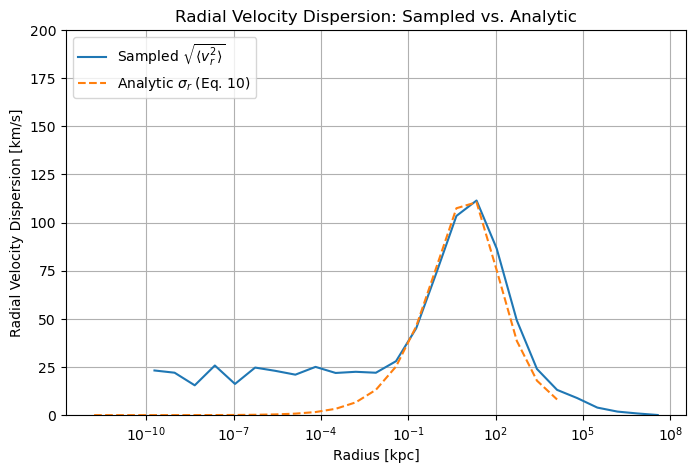

In [48]:
def vr_true(r):
    term1 = gn * mtot / (12 * aa)
    term2 = 12 * r * (r + aa)**3 / aa**4 * np.log((r + aa) / r)
    term3 = r / (r + aa) * (25 + 52 * r / aa + 42 * (r / aa)**2 + 12 * (r / aa)**3)
    return term1 * (term2 - term3)

analytic_disp = vr_true(bin_centers)

plt.figure(figsize=(8, 5))
plt.plot(bin_centers, np.sqrt(v_mean), label='Sampled $\\sqrt{\\langle v_r^2 \\rangle}$')
plt.plot(bin_centers, np.sqrt(analytic_disp), '--', label='Analytic $\\sigma_r$ (Eq. 10)')
plt.xscale('log')
#plt.yscale ('log')
plt.ylim(0, 200)
plt.xlabel('Radius [kpc]')
plt.ylabel('Radial Velocity Dispersion [km/s]')
plt.title('Radial Velocity Dispersion: Sampled vs. Analytic')
plt.grid(True)
plt.legend()
plt.show()

It was incredibly difficult to get an answer working for this problem. Error after error came up and each led down a rabbit hole of weird packages. It did suggest ways to make the code faster, which I appreciated at first, but none ended up working. I ended up having to give it some of my code after trying to explain with words didn't work, but it just copied what I had. It completely failed to come up with a working solution by itself, but somehow got a better match between the analytic and sampled radial velocity distribution although I cannot find where the code is different to account for this. So it actually ended up being a slightly better version of my code as the solution it eventually arrived at is more correct than my own. That being said, it needed my code to get a solution at all and so I consider it to be a complete failure for this problem. One last thing is it did not add any comments explaining what it was doing in the final iteration. 

1.2
-

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
G = 4 * np.pi**2  # AU^3 / (yr^2 M_sun)
M = 1.0           # M_sun
a = 1.0           # AU
e = 0.96          # eccentricity

# Derived values
rp = a * (1 - e)
vp = np.sqrt(G * M * (1 + e) / (a * (1 - e)))

# Initial conditions
r0 = np.array([0.0, rp])
v0 = np.array([-vp, 0.0])
y0 = np.concatenate((r0, v0))  # y = [x, y, vx, vy]

def derivatives(y):
    r = y[:2]
    v = y[2:]
    r_mag = np.linalg.norm(r)
    a = -G * M * r / r_mag**3
    return np.concatenate((v, a))

def rk4_step(f, y, dt):
    k1 = f(y)
    k2 = f(y + 0.5 * dt * k1)
    k3 = f(y + 0.5 * dt * k2)
    k4 = f(y + dt * k3)
    return y + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

def integrate_fixed(y0, f, tmax, dt):
    times = [0.0]
    states = [y0.copy()]
    y = y0.copy()
    t = 0.0
    while t < tmax:
        y = rk4_step(f, y, dt)
        t += dt
        states.append(y.copy())
        times.append(t)
    return np.array(times), np.array(states)

# Try 1 year with 3 timestep choices
steps = {
    "1 month": 1/12,
    "1 week": 1/48,
    "1 day": 1/365.25
}
tmax = 1.0  # year

results = {}
for label, dt in steps.items():
    t, y = integrate_fixed(y0, derivatives, tmax, dt)
    results[label] = (t, y)

# Compute errors
r_true = y0[:2]
E_true = 0.5 * np.dot(y0[2:], y0[2:]) - G * M / np.linalg.norm(y0[:2])

print("Fixed timestep errors:")
for label, (t, y) in results.items():
    r_final = y[-1, :2]
    E_final = 0.5 * np.dot(y[-1, 2:], y[-1, 2:]) - G * M / np.linalg.norm(r_final)
    pos_error = np.linalg.norm(r_final - r_true)
    E_error = abs((E_final - E_true) / E_true)
    print(f"{label:>8}: Position Error = {pos_error:.3e}, Energy Error = {E_error:.3e}")


Fixed timestep errors:
 1 month: Position Error = 3.455e+02, Energy Error = 3.024e+03
  1 week: Position Error = 9.553e+01, Energy Error = 2.320e+02
   1 day: Position Error = 1.231e+01, Energy Error = 4.190e+00


In [4]:
def rk4_adaptive_step(f, y, t, dt, eps_goal):
    y1 = rk4_step(f, y, dt)
    y_half = rk4_step(f, y, dt / 2)
    y2 = rk4_step(f, y_half, dt / 2)

    eps_rel = np.linalg.norm(y1 - y2) / np.linalg.norm(y2)
    dt_new = dt * (eps_goal / eps_rel)**0.2

    if eps_rel <= eps_goal:
        return y2, t + dt, dt_new, True
    else:
        return y, t, dt_new, False


In [6]:
def integrate_adaptive(y0, f, tmax, dt0, eps_goal):
    t = 0.0
    y = y0.copy()
    dt = dt0

    times = [t]
    states = [y.copy()]
    dts = [dt]

    while t < tmax:
        y_new, t_new, dt_new, accepted = rk4_adaptive_step(f, y, t, dt, eps_goal)
        if accepted:
            y = y_new
            t = t_new
            times.append(t)
            states.append(y.copy())
            dts.append(dt)
        dt = min(dt_new, tmax - t)  # prevent overshooting

    return np.array(times), np.array(states), np.array(dts)


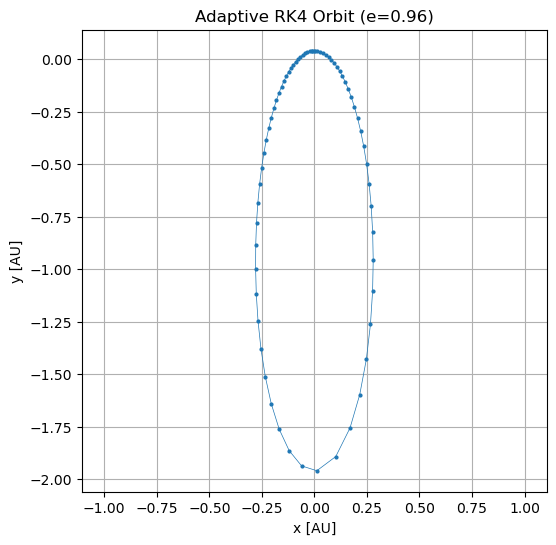

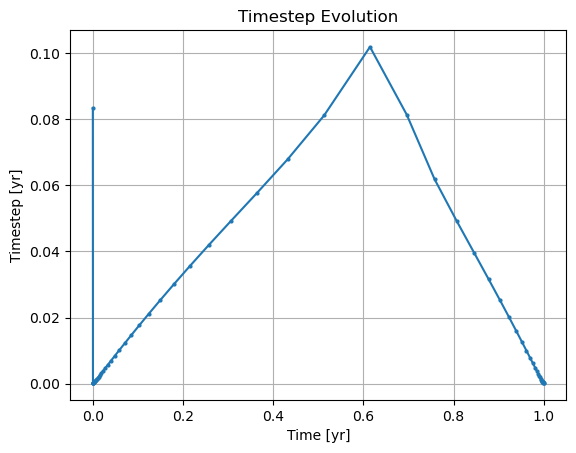

In [8]:
eps_goal = 1e-5
dt_init = 1/12

t_adapt, y_adapt, dt_arr = integrate_adaptive(y0, derivatives, tmax, dt_init, eps_goal)

# Orbit plot with adaptive timesteps
plt.figure(figsize=(6,6))
plt.plot(y_adapt[:,0], y_adapt[:,1], '-o', ms=2, lw=0.5)
plt.xlabel("x [AU]")
plt.ylabel("y [AU]")
plt.title("Adaptive RK4 Orbit (e=0.96)")
plt.axis("equal")
plt.grid()

# Timestep evolution plot
plt.figure()
plt.plot(t_adapt, dt_arr, '-o', ms=2)
plt.xlabel("Time [yr]")
plt.ylabel("Timestep [yr]")
plt.title("Timestep Evolution")
plt.grid()
plt.show()


This one was very easy to get a solution for on the first try, I did not need to supply any code or explanations or even require additional iterations. The solution was correct the first time, and although it made a few different choices, such as having energy errors in the form abs((E_final - E_true) / E_true) instead of (E_final - E_true), all the error values are incredibly similar to my own and the plots of the orbit and timestep evolution are practically identical to mine. But again, it did not add any comments on the steps and had an unnecessary block of code. 

1.3
-

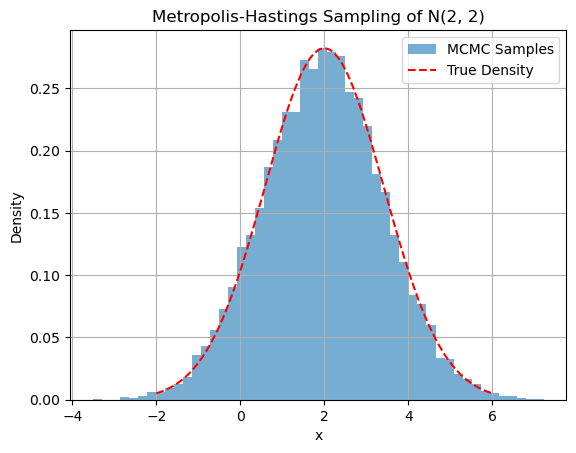

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Target: N(2, 2)
def p(x):
    return norm.pdf(x, loc=2, scale=np.sqrt(2))

# Proposal: N(x, 1)
def metropolis_hastings(p, proposal_std, x0, n_steps):
    samples = np.zeros(n_steps)
    x = x0
    for i in range(n_steps):
        x_prime = np.random.normal(x, proposal_std)
        accept_ratio = p(x_prime) / p(x)
        if np.random.rand() < accept_ratio:
            x = x_prime
        samples[i] = x
    return samples

# Run sampler
n_steps = 20000
samples = metropolis_hastings(p, proposal_std=1.0, x0=0.0, n_steps=n_steps)

# Plot
x_vals = np.linspace(-2, 6, 500)
plt.hist(samples, bins=50, density=True, alpha=0.6, label='MCMC Samples')
plt.plot(x_vals, p(x_vals), 'r--', label='True Density')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend()
plt.title('Metropolis-Hastings Sampling of N(2, 2)')
plt.grid()
plt.show()


In this case the LLM gave a solution on the first attempt, very quickly and easily, and it matches my own and the Hogg & Foreman-Mackey solution shown in the paper.  

Conclusion:
-
LLMs are not capable of solving all problems. While they may be able to do direct implementations and work through step by step problems, they appear to struggle immensly with any complex multilayer sampling methods. Additionally while they may be able to "replace our brain" for certain problems, there is a danger of becoming reliant on LLMs to the point where we are no longer able to discern if or where they are going wrong. Personally, I do not think LLMs are capable of or should be able to replace our brains at this point. I also do not hope that it will be capable of this in the future. In certain scenarios it can be a useful tool for straightforward or repeated actions, but I think as scientists we have duty to implement our own thoughts and methodologies in relation to original ideas, and in many senses LLMs are the antithesis of this idea.

2
-

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as s_int
import time
import pyro.mesh.boundary as bnd
import pyro.mesh.patch as patch
from pyro import Pyro

In [16]:
#generate uniform random positions in 3D for N equal mass particles
def gen_positions(N, seed=1214):
    #set seed
    np.random.seed(seed)
    #random unifrom positions
    return np.random.uniform(0, 100, size=(N, 3))

Text(0.5, 0.92, 'Random Positions of 1000 Particles in 3D')

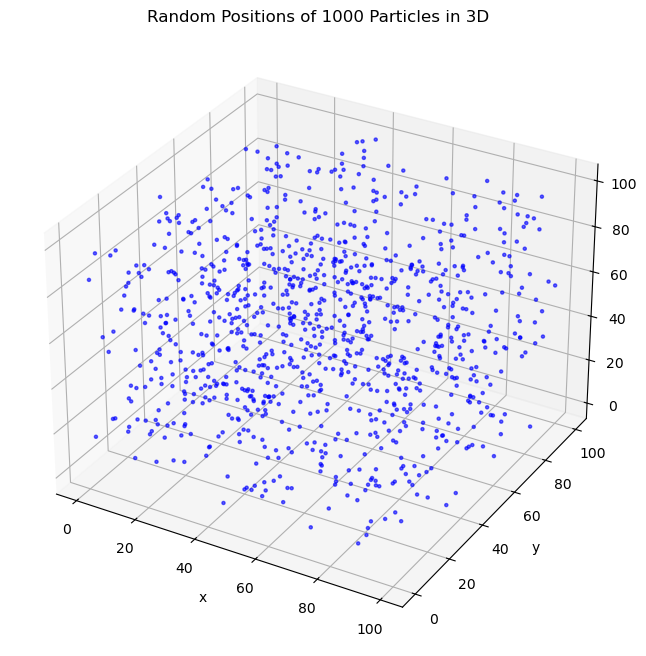

In [18]:
#check position generation via plotting
N = 1000
positions = gen_positions(N)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1,1,1, projection='3d')

ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], color='blue', s=5, alpha=0.6)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z', labelpad=10) #for some reason the z label won't show up no matter what...
ax.set_title(f'Random Positions of 1000 Particles in 3D')


In [20]:
#direct method of calculating acceleration of every particle but now with periodic boundary conditions
def direct_acceleration(positions):
    #set grav constant to 1.0 for now as no units in problem
    G=1.0
    #number of particles
    N=positions.shape[0]
    #initialize acceleration arr
    net_acceleration=np.zeros_like(positions)
    #dtermine acceleration
    for i in range(N):
        #position difference to the other paricles
        displace=positions-positions[i]

        #implement periodic boundary
        boxsize=100
        #displacement in box unit
        boxl=displace/boxsize
        #calculate number of boxes to subtract (rounded)
        wrapbox=np.round(boxl)
        #box unit back to physical
        wrap=wrapbox*boxsize
        #apply
        place=displace-wrap
    
        
        #magnitude of distance to other particles
        mag=np.linalg.norm(place, axis=1)
        #mask including all other particles, so can make sure no self interaction
        mask=np.arange(N)!=i
        #gravitational acceleration from every other particle
        acceleration=G*place[mask]/mag[mask][:, None]**3
        #sum accerlerations to get net acc
        net_acceleration[i]=np.sum(acceleration, axis=0)
    return net_acceleration

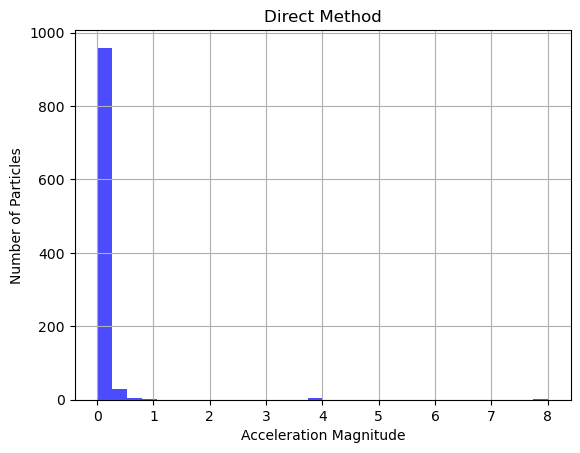

In [22]:
#check direct method via plotting
N = 1000
positions = gen_positions(N)
accelerations=direct_acceleration(positions)

#get magnitude of accelerations
mag_accelerations=np.linalg.norm(accelerations, axis=1)

plt.hist(mag_accelerations, bins=30, alpha=0.7, color='blue')
plt.xlabel("Acceleration Magnitude")
plt.ylabel("Number of Particles")
plt.title("Direct Method")
plt.grid(True)
plt.show()

In [26]:
#test for 10**5
#different numbers of particles
N=[10**5]

#initialize lists to store times
direct_times=[]

direct_accs = []
            
#find times for different N by method
for N_i in N:
    positions=gen_positions(N_i)

    #direct times
    if N_i > 10**5:
        direct_prog = None
        direct_accs.append(None)
    else:
        print(f"Running direct method for N = {N_i}")
        start = time.time()
        acc = direct_acceleration(positions)
        direct_prog = time.time() - start
        direct_accs.append(acc)

    direct_times.append(direct_prog)

    direct_str = f"{direct_prog:.4f}" if direct_prog is not None else "infeasible"
    print(f"N={N_i} | Direct Time (s)={direct_str}")

Running direct method for N = 100000
N=100000 | Direct Time (s)=513.5146


When implementing periodic boundary conditions, the only thing abaout my calculation that changed is that instead of just computing distances between particles, the particles near opposite sides now interact so that the distances between particles can now be shorter if we consider the sides to wrap around. I think this is a better way to calculate forces as particlaes will now exert more accurate forces. The timing was just slightly longer, about a minute, which I do not view as too big a change to implement if you are doing a limited number of calculations. If I were to use a KDTree to do this problem, after building a KDTRee I would implement some cutoff distance for forces, then use the KDTree to get pairs within that distance but make sure to have aperiodic boundary condition so that particles near opposite edges wrap and are still close, and then when I compute the force vectors I would also apply the periodic boundary condition to make sure I compute the shortest ditance between particles.